# CSCI 550: Mini Project 01

Submitted By: Ramisha Fariha Baki, Tadeo Aviles Zuniga, Muhammad Sana, Lina-Sophie Hommel

In [1]:
import seaborn as sns
sns.set()

In [2]:
pip install igraph

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.4/4.4 MB 24.7 MB/s eta 0:00:00


In [3]:
pip install requests-futures

# The New York Social Graph


[New York Social Diary](https://www.newyorksocialdiary.com/) provides a
fascinating lens onto New York's socially well-to-do.  The data forms a natural social graph for New York's social elite.  Take a look at this page of a recent [To Love Unconditionally](https://www.newyorksocialdiary.com/to-love-unconditionally/).

You will notice the photos have carefully annotated captions labeling those that appear in the photos.  We can think of this as implicitly implying a social graph: there is a connection between two individuals if they appear in a picture together.

For this project, we will assemble the social graph from photo captions for parties.  Using this graph, we can make guesses at the most popular socialites, the most influential people, and the most tightly coupled pairs.

We will attack the project in three phases:
1. Get a list of all the photo pages to be analyzed.
2. Get all captions in each party, Parse all of the captions and extract guests' names.
3. Assemble the graph, analyze the graph and answer the questions

## Phase One (20 pts)


The first step is to crawl the data.  We want photos from parties on or before December 1st, 2014.  Go to the [Party Pictures Archive](https://web.archive.org/web/20150913224145/http://www.newyorksocialdiary.com/party-pictures) to see a list of (party) pages.  We want to get the url for each party page, along with its date.

Here are some packages that you may find useful.  You are welcome to use others, if you prefer.

In [4]:
import requests
import dill
from bs4 import BeautifulSoup
from datetime import datetime
from urllib.parse import urljoin
import pandas as pd
import time
import matplotlib.pyplot as plt
import re
import numpy as np
import random
import igraph as ig, numpy as np
from collections import defaultdict


We recommend using Python [Requests](http://docs.python-requests.org/en/master/) to download the HTML pages, and [BeautifulSoup](https://www.crummy.com/software/BeautifulSoup/) to process the HTML.  Let's start by getting the [first page](https://web.archive.org/web/20150913224145/http://www.newyorksocialdiary.com/party-pictures).

In [5]:
import time
from requests.exceptions import RequestException

# We started from page 2
url='https://web.archive.org/web/20150918040703/http://www.newyorksocialdiary.com/party-pictures?page=1'

# Implement a retry mechanism for the request
max_retries = 5
for attempt in range(max_retries):
    try:
        page = requests.get(url)
        page.raise_for_status()  # Raise an HTTPError for bad responses (4xx or 5xx)
        break  # If the request was successful, break out of the loop
    except RequestException as e:
        print(f"Attempt {attempt+1} failed: {e}")
        if attempt < max_retries - 1:
            time.sleep(2**attempt)  # Exponential backoff
        else:
            print("Max retries reached. Could not retrieve the page.")
            page = None # Ensure page is None if all retries fail

if page:
    print("Successfully retrieved the page.")
else:
    print("Failed to retrieve the page after multiple retries.")

page

Successfully retrieved the page.


<Response [200]>

Now, we process the text of the page with BeautifulSoup.

In [6]:
soup = BeautifulSoup(page.text, "lxml")
soup

<!DOCTYPE html>
<!--[if IEMobile 7]><html class="no-js ie iem7" lang="en" dir="ltr"><![endif]--><!--[if lte IE 6]><html class="no-js ie lt-ie9 lt-ie8 lt-ie7" lang="en" dir="ltr"><![endif]--><!--[if (IE 7)&(!IEMobile)]><html class="no-js ie lt-ie9 lt-ie8" lang="en" dir="ltr"><![endif]--><!--[if IE 8]><html class="no-js ie lt-ie9" lang="en" dir="ltr"><![endif]--><!--[if (gte IE 9)|(gt IEMobile 7)]><html class="no-js ie" lang="en" dir="ltr" prefix="fb: http://ogp.me/ns/fb# og: http://ogp.me/ns# article: http://ogp.me/ns/article# book: http://ogp.me/ns/book# profile: http://ogp.me/ns/profile# video: http://ogp.me/ns/video# product: http://ogp.me/ns/product#"><![endif]--><!--[if !IE]><!--><html class="no-js" dir="ltr" lang="en" prefix="fb: http://ogp.me/ns/fb# og: http://ogp.me/ns# article: http://ogp.me/ns/article# book: http://ogp.me/ns/book# profile: http://ogp.me/ns/profile# video: http://ogp.me/ns/video# product: http://ogp.me/ns/product#"><!--<![endif]-->
<head><script charset="utf-8"

This page has links to 50 party pages. Look at the structure of the page and determine how to isolate those links.  Your browser's developer tools (usually `Cmd`-`Option`-`I` on Mac, `Ctrl`-`Shift`-`I` on others) offer helpful tools to explore the structure of the HTML page.

Once you have found a pattern, use BeautifulSoup's [select](https://www.crummy.com/software/BeautifulSoup/bs4/doc/#css-selectors) or [find_all](https://www.crummy.com/software/BeautifulSoup/bs4/doc/#find) methods to get those elements.

In [7]:
all_parties=soup.find('div',class_='view-content')

In [8]:
links = all_parties.find_all('div',class_="views-row")

There should be 50 per page.

In [9]:
len(links) == 50

True

Let's take a look at that first link.  Figure out how to extract the URL of the link, as well as the date.  You probably want to use `datetime.strptime`.  See the [format codes for dates](https://docs.python.org/3/library/datetime.html#strftime-and-strptime-behavior) for reference.

In [ ]:
"/web/20150913224145/http://www.newyorksocialdiary.com/party-pictures/2015/grand-finale-of-the-hampton-classic-horse-show">Grand Finale of the Hampton Classic Horse Show</a>

In [10]:
link = links[0]
a = link.find('a')
title=a.text.strip()
href=a["href"]
date_text=link.find_all('span',class_='field-content')[1].get_text(strip=True)
date_dt=datetime.strptime(date_text, "%A, %B %d, %Y")

print(title)
print(href)
print(date_text)
# Check that the title and date match what you see visually.

Bunny Hop, The Boys' Club, Old Bags, and more ...
/web/20150918040703/http://www.newyorksocialdiary.com/party-pictures/2015/bunny-hop-the-boys-club-old-bags-and-more
Friday, March 13, 2015


For purposes of code reuse, let's put that logic into a function.  It should take the link element and return the URL and date parsed from it.

In [11]:
#4p
def get_link_date(el):
    a = link.find('a')
    title=a.text.strip()
    url=a["href"]
    date_text=link.find_all('span',class_='field-content')[1].get_text(strip=True)
    date=datetime.strptime(date_text, "%A, %B %d, %Y")
    return url, date

You may want to check that it works as you expected.

Once that's working, let's write another function to parse all of the links on a page.  Thinking ahead, we can make it take a Requests [Response](https://requests.readthedocs.io/en/master/api/#requests.Response) object and do the BeautifulSoup parsing within it.

In [12]:
#4p
def get_links(response):
  soup = BeautifulSoup(response.text, "lxml")
  parties=soup.find('div',class_='view-content')
  pairs = []
  links_to_parties = parties.find_all('div',class_="views-row")
  for link in links_to_parties:
        a = link.find('a')
        href = a['href']
        date_text = link.find_all('span', class_='field-content')[1].get_text(strip=True)
        dt = datetime.strptime(date_text, "%A, %B %d, %Y")
        pairs.append((href, dt))
  return pairs # A list of URL, date pairs

If we run this on the previous response, we should get 50 pairs.

In [13]:
# These should be the same links from earlier
len(get_links(page)) == 50

True

But we only want parties with dates on or before the first of December, 2014.  Let's write a function to filter our list of dates to those at or before a cutoff.  Using a keyword argument, we can put in a default cutoff, but allow us to test with others.

In [14]:
#2p
def filter_by_date(links, cutoff=datetime(2014, 12, 1)):
    return [(url, dt) for (url, dt) in links if dt <= cutoff]

With the default cutoff, there should be no valid parties on the first page.  Adjust the cutoff date to check that it is actually working.

In [15]:
# Double check the dates are being extracted correctly
page=requests.get('https://web.archive.org/web/20150918040747/http://www.newyorksocialdiary.com/party-pictures')
len(filter_by_date(get_links(page))) == 0

True

**<span style="color:red">!!! We are now ready to retrieve all of the party URLs. However, for this assignment you won’t need to collect the full set, as data will be provided to you. This step is included primarily for your learning.</span>**

Click through a few of the index pages to determine how the URL changes.  Figure out a strategy to visit all of them.

HTTP requests are generally IO-bound.  This means that most of the time is spent waiting for the remote server to respond.  If you use `requests` directly, you can only wait on one response at a time.  [requests-futures](https://github.com/ross/requests-futures) lets you wait for multiple requests at a time.  You may wish to use this to speed up the downloading process.

In [16]:
from requests_futures.sessions import FuturesSession

link_list = []
SNAP = "20150918040703"
def page_url(i):
    return f"https://web.archive.org/web/{SNAP}/http://www.newyorksocialdiary.com/party-pictures?page={i}"

session = FuturesSession(max_workers=8)


futures = [(i, session.get(page_url(i), timeout=30)) for i in range(2, 27)]

for i, fut in futures:
    try:
        resp = fut.result()
        print(f"page {i} -> {resp.status_code}")
        if not resp.ok:
            continue

        pairs = get_links(resp)
        kept = filter_by_date(pairs)


        link_list.extend([href for href, _dt in kept])

       # print(f"  got {len(pairs)} rows, kept {len(kept)} after cutoff")

    except Exception as e:
        print(f"page {i} failed:", e)


page 2 -> 200
page 3 -> 200
page 4 -> 200
page 5 -> 200
page 6 -> 200
page 7 -> 200
page 8 -> 200
page 9 -> 200
page 10 -> 200
page 11 -> 200
page 12 -> 200
page 13 -> 200
page 14 -> 200
page 15 -> 200
page 16 -> 200
page 17 -> 200
page 18 -> 200
page 19 -> 200
page 20 -> 200
page 21 -> 200
page 22 -> 200
page 23 -> 200
page 24 -> 200
page 25 -> 200
page 26 -> 200


In the end, you should have 1193 parties.

In [17]:
# Make sure you are using the same /web/stringofdigits/... for each page
# This is to prevent the archive from accessing later copies of the same page
# If you are off by a just a few, that can be the archive misbehaving
len(link_list) == 1193

True

In case we need to restart the notebook, we should save this information to a file.  There are many ways you could do this; here's one using `dill`.

In [18]:
dill.dump(link_list, open('nysd-links.pkd', 'wb'))

To restore the list, we can just load it from the file.  When the notebook is restarted, you can skip the code above and just run this command.

In [19]:
link_list = dill.load(open('nysd-links.pkd', 'rb'))

Now, let’s carry out some preliminary analysis using the provided Parties_Data.csv file. Answer Question 1 and Question 2 using the full dataset

In [20]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Question 1: In which month did most of the parties occur?
hint: we are interested in monthly aggregates(5 p)
### Question 2: What is the overall trend of parties from 2007 to 2014? (5 p)
hint: We are interested in a time series visualization. You may apply a moving average to smooth the data and highlight the overall trend.
Use visualizations to answer the two questions above. Ensure that you interpret your plots thoroughly.

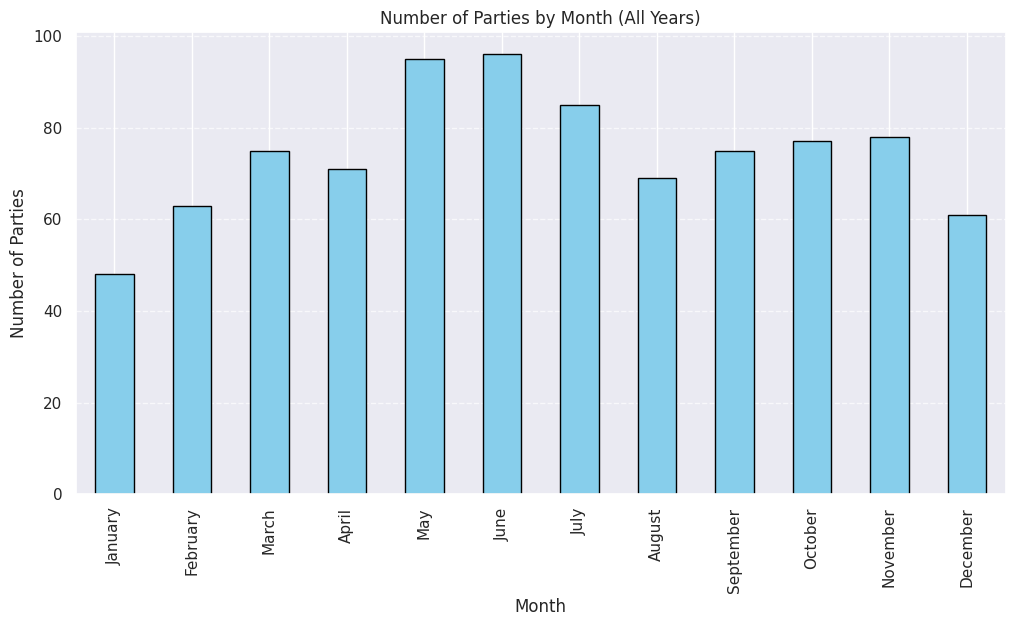


Most parties occurred in June, with 96 parties in total across all years.


In [21]:
df = pd.read_csv("/content/drive/MyDrive/CSCI 550/Mini_Project01/Parties_Data.csv")
df["date"] = pd.to_datetime(df["date"])
df["month_name"] = df["date"].dt.strftime("%B")
month_totals = df["month_name"].value_counts()
month_totals = month_totals.reindex([
    "January", "February", "March", "April", "May", "June",
    "July", "August", "September", "October", "November", "December"
])

top_month = month_totals.idxmax()
top_count = month_totals.max()
# Plot
plt.figure(figsize=(12, 6))
month_totals.plot(kind="bar", color="skyblue", edgecolor="black")

plt.title("Number of Parties by Month (All Years)")
plt.xlabel("Month")
plt.ylabel("Number of Parties")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

print(f"\nMost parties occurred in {top_month}, with {top_count} parties in total across all years.")

**Answer to Question 01:** Most parties occurred in June, with 96 parties in total across all years.

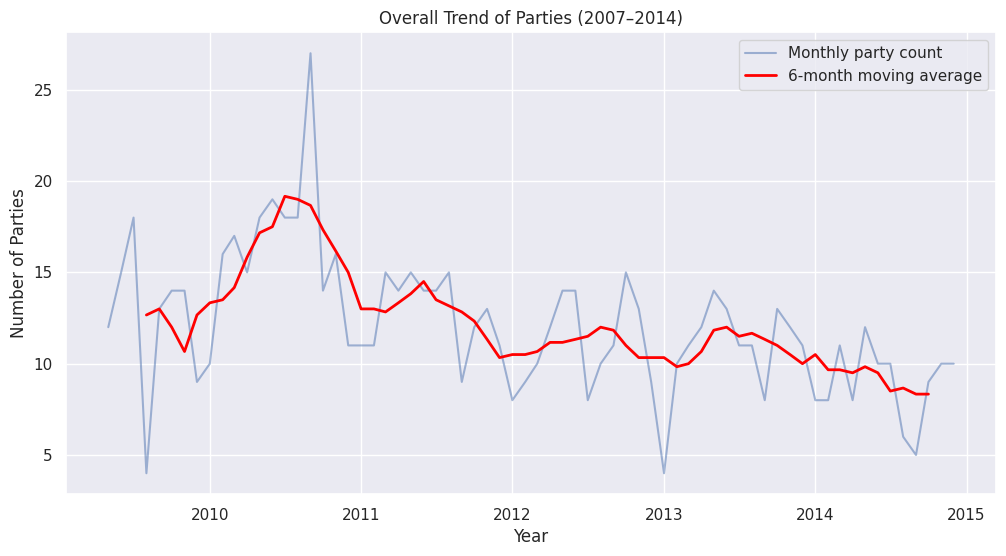

In [22]:
df_copy = df[(df["date"].dt.year >= 2007) & (df["date"].dt.year <= 2014)]


monthly_counts = df_copy.groupby(df_copy["date"].dt.to_period("M")).size()
monthly_counts.index = monthly_counts.index.to_timestamp()  # for plotting


smoothed = monthly_counts.rolling(window=6, center=True).mean()

# Plot
plt.figure(figsize=(12, 6))
plt.plot(monthly_counts.index, monthly_counts.values, label="Monthly party count", alpha=0.5)
plt.plot(smoothed.index, smoothed.values, label="6-month moving average", linewidth=2, color="red")
plt.title("Overall Trend of Parties (2007–2014)")
plt.xlabel("Year")
plt.ylabel("Number of Parties")
plt.legend()
plt.grid(True)
plt.show()

**Answer to Question 02:** The 6-month moving average rises to a peak in 2010—highest in the second half of the year—then declines and stabilizes around 9–11 parties per month from 2012 to 2014. Overall: a 2010 peak followed by a downward trend to a lower, steady level.


## Phase Two (40 pts)


In this phase, we concentrate on getting the names out of captions for a given page.  We'll start with [the benefit cocktails and dinner](https://web.archive.org/web/20150913224145/http://www.newyorksocialdiary.com/party-pictures/2015/celebrating-the-neighborhood) for [Lenox Hill Neighborhood House](http://www.lenoxhill.org/), a neighborhood organization for the East Side.

Take a look at that page.  Note that some of the text on the page is captions, but others are descriptions of the event.  Determine how to select only the captions.

In [23]:
#5p
url='https://web.archive.org/web/20151114014941/http://www.newyorksocialdiary.com/party-pictures/2015/celebrating-the-neighborhood'
page_p2 = requests.get(url)
soup_p2 = BeautifulSoup(page_p2.text, "lxml")
photos = soup_p2.find('div',class_='field__item even')
captions = photos.find_all('div',class_='photocaption')
len(captions)

109

By our count, there are about 110.  But if you're off by a couple, you're probably okay.

In [24]:
# These are for the specific party referenced in the text
abs(len(captions) - 110) < 5

True

Let's encapsulate this in a function.  As with the links pages, we want to avoid downloading a given page the next time we need to run the notebook.  While we could save the files by hand, as we did before, a checkpoint library like [ediblepickle](https://pypi.python.org/pypi/ediblepickle/1.1.3) can handle this for you.  (Note, though, that you may not want to enable this until you are sure that your function is working.)

You should also keep in mind that HTTP requests fail occasionally, for transient reasons.  You should plan how to detect and react to these failures.   The [retrying module](https://pypi.python.org/pypi/retrying) is one way to deal with this.

In [25]:
#5p
def get_captions(path):
  page_p2 = requests.get(url)
  soup_p2 = BeautifulSoup(page_p2.text, "lxml")
  photos = soup_p2.find('div',class_='field__item even')
  captions = photos.find_all('div',class_='photocaption')
  return captions

This should get the same captions as before.

In [26]:
# This cell is expecting get_captions to return a list of the captions themselves
# Other routes to a solution might need to adjust this cell a bit
captions == get_captions("/web/20150913224145/http://www.newyorksocialdiary.com/party-pictures/2015/celebrating-the-neighborhood")
#captions

True

**<span style="color:red">!!! As in the previous phase, writing the function to scrape the captions is sufficient. You don’t need to collect captions for all parties. For the next part of the project (name extraction), you can use the provided dataset.</span>**

### Names Extraction

Now that we have some sample captions, let's start parsing names out of those captions.  There are many ways of going about this, and we leave the details up to you.  Some issues to consider:

  1. Long captions are often not lists of people.  The cutoff is subjective, but for grading purposes, *set that cutoff at 250 characters*.
  2. You will want to separate the captions based on various forms of punctuation.  Try using `re.split`, which is more sophisticated than `string.split`. **Note: Use regex exclusively for name parsing.**
  3. You might find a person named "ra Lebenthal".  There is no one by this name.  Can you spot what's happening here?
  4. This site is pretty formal and likes to say things like "Mayor Michael Bloomberg" after his election but "Michael Bloomberg" before his election.  Can you find other titles that are being used?  They should probably be filtered out because they ultimately refer to the same person: "Michael Bloomberg."
  5. There is a special case you might find where couples are written as eg. "John and Mary Smith". You will need to write some extra logic to make sure this properly parses to two names: "John Smith" and "Mary Smith".
  6. When parsing names from captions, it can help to look at your output frequently and address the problems that you see coming up, iterating until you have a list that looks reasonable. Because we can only asymptotically approach perfect identification and entity matching, we have to stop somewhere.
  
**Questions worth considering:**
  1. Who is Patrick McMullan and should he be included in the results? How would you address this?
  2. What else could you do to improve the quality of the graph's information?

Taking into account the challenges mentioned above, as well as any others you may encounter, define an algorithm using different regex rules and logic. Then, test your algorithm on your sample page [the benefit cocktails and dinner](https://web.archive.org/web/20150913224145/http://www.newyorksocialdiary.com/party-pictures/2015/celebrating-the-neighborhood)
regex101.com is a wondeful resource to learn and test your logics on a sample text.

Once you feel that your algorithm is working well on these captions of this page, parse all of the captions and extract all the names mentioned. Sort them alphabetically, by first name, and return the first hundred.

In [36]:
# Final caption parser — 25 pts


# -------- regex rules --------
ROW_SPLIT_RE = re.compile(r"\s*\|\s*|¬|[\r\n]+|;")
PREFIXES_RE = re.compile(
    r"\b("
    r"Mr|Mrs|Ms|Miss|Mx|Dr|Prof|Professor|Hon|Hon\.|The Hon\.?|Sir|Dame|Rev|Rev\.|Father|Fr\.|Rabbi|Imam|Sheikh|Sheik|"
    r"Mayor|Governor|Gov|Senator|Sen|Representative|Rep|Councilmember|Councilman|Councilwoman|Ambassador|Judge|Justice|"
    r"Count|Countess|Duke|Duchess|Baron|Baroness|Prince|Princess|Queen|King|President|First\s+Lady"
    r")\b\.?",
    re.IGNORECASE,
)
SUFFIXES_RE  = re.compile(r"\b(Jr|Sr|II|III|IV|V|PhD|MD|Esq|0)\b\.?", re.IGNORECASE)
SPLIT_RE     = re.compile(r"[;,]|(?:\s[-–—]\s)|\s(?:and|&)\s|/|:")
COUPLE_RE = re.compile(
    r"^\s*([A-Z][a-z’'\-]+)\s+(?:and|&)\s+([A-Z][a-z’'\-]+)\s+([A-Z][a-z’'\-]+)\b"
)
NAME_TOKEN = (
    r"(?:"
    r"[A-Z][a-z]+(?:[’'][A-Za-z]+|-[A-Z]?[a-z]+)*"
    r"|O[’'][A-Z][a-z]+"
    r"|D[’'][A-Z][a-z]+"
    r"|Mc[A-Za-z]+"
    r"|St\.?\s*[A-Z][a-z]+"
    r")"
)
FULLNAME_RE = re.compile(rf"\b{NAME_TOKEN}(?:\s+{NAME_TOKEN}){{1,3}}\b")
# roles/titles
# org/institution
# events/venues
ORG_WORDS = re.compile(r"""
\b(

    Former|Deputy|Borough|City|State|Lt|Lieutenant|Comptroller|Commissioner|Consul|Ambassador|
    Honor(?:ee|ary)|Trustee[s]?|Board|Chair(?:man|woman)?|Vice|President|Director|Executive|
    Advisor|Advisory|Founder|Member
    |Institute|Foundation|Museum|Center|House|School|University|College|Company|Co\.?|Inc\.?|LLC|LLP|Ltd\.?|
    Gallery|Club|Committee|Council|Association|Society|Hospital|Medical|Academy|Fund|Bank|Partners?|Capital|
    Media|Group|Studio|Theatre|Theater|Hotel|Resort|Realty
    |Annual|Gala|Dinner|Party|Ball|Opening|Autumn|Spring|Summer|Benefit|Auction|Award[s]?|Festival|
    Concert|Night|Room|Choir|Orchestra|Quartet|Fashion|Show|Cafe
)\b
""", re.IGNORECASE | re.VERBOSE)

# Multi-word org/event phrases that slipped into the old ORG_WORDS as raw text
ORG_PHRASES = re.compile(r"""
    \bNew\s+Year(?:'s)?\s+Eve\b|
    \bNew\s+York(?:\s+(?:Bravest|Circle|Winter\s+Ball|Philharmonic(?:\s+Spring)?|City))\b|
    \bCentral\s+Park\s+Conservancy\b|
    \bWomen(?:'s)?\s+(?:Board|Forum|Health)\b|
    \bWooster\s+Collective\b|
    \bLouvre\s+Young\s+Patrons\s+Circle\b
""", re.IGNORECASE | re.VERBOSE)

# Phrases that were found aftwerwards running the two above rules were hard coded into Bad Phrases (e.g. photographers)
BAD_PHRASES = re.compile(r"""
\b(
    Executive\s+Director|
    The|
    by\s+Patrick\s+McMullan|
    Abbott\s+House(?:\b|\s+(?:Award(?:s)?|Board(?:\s+(?:Chair(?:man)?|Vice(?:\s+Chair)?|President|Member))?))|
    Peyton\s+Hoge(?:\s*\(Frist\))?|
    Paul\s+Bruinooge
)\b
""", re.IGNORECASE | re.VERBOSE)



def _preclean(s: str) -> str:
    if not isinstance(s, str):
        return ""
    s = s.replace("’", "'").replace("‘", "'")
    s = re.sub(r"([A-Za-z])-\s*[\r\n]+\s*([A-Za-z])", r"\1-\2", s)
    return s

def _strip_titles(text: str) -> str:
    text = PREFIXES_RE.sub(" ", text)
    text = SUFFIXES_RE.sub(" ", text)
    return re.sub(r"\s+", " ", text).strip()

def _expand_couples_head(text: str):
    m = COUPLE_RE.match(text)
    if not m:
        return [], text
    f1, f2, last = m.groups()
    return [f"{f1} {last}", f"{f2} {last}"], text[m.end():]

def _extract_names_from_caption(caption: str):
    if not isinstance(caption, str):
        return []
    cap = _strip_titles(caption)

    names = []

    base_chunks = (p.strip() for p in re.split(r"[;,]|(?:\s[-–—]\s)|/|:", cap) if p and p.strip())
    for chunk in base_chunks:
        extra, chunk = _expand_couples_head(chunk)
        names.extend(extra)

        # Scanning for names in the remaining chunk
        for m in FULLNAME_RE.finditer(chunk):
          cand = m.group(0)
          cand = re.sub(r"([A-Za-z])[’']s\b", r"\1", cand)
          if any(tok.endswith(("'", "’", "-")) for tok in cand.split()):
            continue
          if ORG_WORDS.search(cand) or ORG_PHRASES.search(cand) or BAD_PHRASES.search(cand):
            continue
          names.append(cand)
    return names




Now, run this sort of test on a few other pages.  You will probably find that other pages have a slightly different HTML structure, as well as new captions that trip up your caption parser.  But don't worry if the parser isn't perfect -- just try to get the easy cases.

Once you are satisfied that your parser is working properly, run this for all of the pages on CSV file.  

In [37]:
# Final caption parser 25 p


def caption_parser(parties_data: pd.DataFrame, captions_col: str = "photo_captions", top_n: int = None):
    all_names = []
    for cap in parties_data[captions_col].dropna().astype(str):
        cap = _preclean(cap)  # your helper (keeps ’/hyphen fixes)
        parts = [p.strip() for p in ROW_SPLIT_RE.split(cap) if p and p.strip()]
        for p in parts:
            if len(p) > 250:
                continue
            all_names.extend(_extract_names_from_caption(p))

    uniq_sorted = sorted(set(all_names), key=lambda s: (s.split()[0], s.split()[1:]))
    return uniq_sorted if top_n is None else uniq_sorted[:top_n]


all_names = caption_parser(df, captions_col="photo_captions", top_n=None)

print("Total unique names extracted:", len(all_names))
print(all_names[:100])





Total unique names extracted: 61322
['Aalika Mahindra', 'Aamba Chavis', 'Aamir Khandwala', 'Aaron Amaro', 'Aaron Bakalar', 'Aaron Baldinger', 'Aaron Dannenberg', 'Aaron Erlanger', 'Aaron Fedor', 'Aaron Fisher', 'Aaron Fossi', 'Aaron Gelbman', 'Aaron Gell', 'Aaron Grossbard', 'Aaron Hicklin', 'Aaron Hollub', 'Aaron Hsu', 'Aaron Kopelowitz', 'Aaron Lazar', 'Aaron Leavitt', 'Aaron Lichtman', 'Aaron Lieber', 'Aaron Malinsky', 'Aaron Marks', 'Aaron Marvin', 'Aaron Matthews', 'Aaron Mickelson', 'Aaron Miller', 'Aaron Mullenioux', 'Aaron Ness', 'Aaron Padin', 'Aaron Paul', 'Aaron Peterson', 'Aaron Rovner', 'Aaron Rutter', 'Aaron Scheer', 'Aaron Schock', 'Aaron Schumm', 'Aaron Sciandra', 'Aaron Sigmond', 'Aaron Smyth', 'Aaron Sorkin', 'Aaron Standish', 'Aaron Starkey', 'Aaron Staton', 'Aaron Steinberg', 'Aaron Stern', 'Aaron Stolpen', 'Aaron Tighe', 'Aaron Tveit', 'Aaron Woolf', 'Aaron Young', 'Aaron Zises', 'Aaron Zych', 'Aasif Mandvi', 'Ab Miles', 'Abagail Durkin', 'Abbe Goldstein', 'Abbe He

Patrick McMullan is a photographer for one of the pictures, and when a caption is including him because he took the photos he should be removed from the caption (normally the captions are like this when he is the Photographer ...by Patrick McMullan); However, all the other times he is being photographed with other people and should then be included in the results.

Non-specific familial references (e.g., ‘… and his daughters,’ ‘… father and son’) should be excluded unless the individuals can be identified, as they add no analytical value. There are also 2 other photographers that we found which were hard coded to remove them as they appeared only in photo credit but not with anybody's picture.

## Phase 3: Graph Analysis (90pts)

For the remaining analysis, we think of the problem in terms of a
network or a graph. Any time a pair of people appear in a photo together, that is considered a link.  It is an example of  an **undirected weighted graph**. We recommend using python's [`networkx`](https://networkx.github.io/) library.

## Question 3: Graph EDA (20 p)


- Use parsed names to create the undirected weighted network and visualize it (5 p)
- Report the number of nodes and edges (5 p)
- What is the diameter of this graph? (5 p)
- What is the average clustering coeff of the graph? How you interpret this number? (5 p)

In [29]:
import itertools
import networkx as nx
import re, itertools, networkx as nx
from itertools import combinations
import igraph as ig
from collections import Counter

In [30]:


def build_graph(parties_data, captions_col="photo_captions"):
    G = nx.Graph()
    all_seen = set()
    for cap in parties_data[captions_col].dropna().astype(str):
        cap = _preclean(cap)
        parts = [p.strip() for p in ROW_SPLIT_RE.split(cap) if p and p.strip()]
        for p in parts:
            if len(p) > 250:
                continue
            names = sorted(set(_extract_names_from_caption(p)))
            if not names:
              continue
            for n in names:
              G.add_node(n)
              G.nodes[n]["count"] = G.nodes[n].get("count", 0) + 1
            if len(names) < 2:
                continue
            for u, v in combinations(names, 2):
                G.add_edge(u, v, weight=G.get_edge_data(u, v, {"weight": 0})["weight"] + 1)
    return G


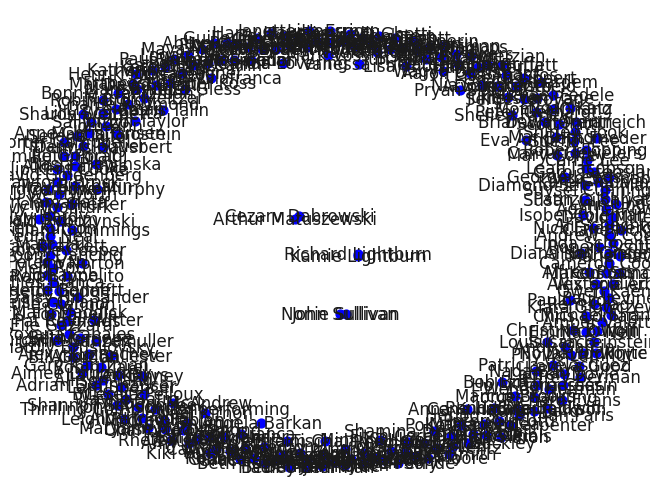

In [31]:
seed = 42
random.seed(seed); np.random.seed(seed)

G = build_graph(df, captions_col="photo_captions")


k = min(300, G.number_of_nodes())
H = G.subgraph(np.random.choice(list(G.nodes()), size=k, replace=False)).copy()

nx.draw(H, with_labels=True, node_color="blue", node_size=40, width=0.5)
plt.show()


In [38]:
print("The number of nodes of this graph is:",G.number_of_nodes())
print("The number of edge of this graph is:",G.number_of_edges())

The number of nodes of this graph is: 61322
The number of edge of this graph is: 97927


In [72]:


# from NetworkX graph G:
names  = list(G.nodes())
edges  = list(G.edges())
weights = [G[u][v].get("weight", 1) for u, v in edges]

# build igraph
G_ig = ig.Graph()
G_ig.add_vertices(len(names))
G_ig.vs["name"] = names

# map names -> indices for igraph edges
name_to_idx = {name: i for i, name in enumerate(names)}
edges_idx = [(name_to_idx[u], name_to_idx[v]) for u, v in edges]

G_ig.add_edges(edges_idx)
G_ig.es["weight"] = weights

print(G_ig.summary())

diameter = G_ig.diameter(directed=False, weights=None)

print("The diameter of this graph is:",diameter)


IGRAPH UNW- 61322 97927 -- 
+ attr: name (v), weight (e)
The diameter of this graph is: 22


In [40]:
avg_cc = nx.average_clustering(G)
print("Average clustering coefficient:", avg_cc)

Average clustering coefficient: 0.45141664850635355




*   The number of nodes of this graph is: 61322

*   The number of edge of this graph is: 97927

*   The diameter of this graph is: 22

*   Average clustering coefficient: 0.45141664850635355

Since Clustering Coefficient is ≈0.45, we can say that on average, about 45% of the possible ties among a person’s neighbors actually exist. That’s a moderate–high level for a sparse graph and is typical of social/event networks, where local friend groups and committees form tight triangles. People who appear in photos together are likely to know each other, so their neighbors often connect too, creating dense local clusters—which fits the nature of this social/event network.
The graph isn’t fully connected, so we report the diameter on the largest connected subgraph. A diameter of 22 means the longest shortest path between any two people in that big component is 22 steps. Thus, we can get from one person to another in 22 co-appearance links or fewer—friends in a photo, whose friends are in other photos, and so on.



## Question 4: Graph properties (25 p)

What real-world graph properties does this graph exhibit? Please show your work and interpret your answer. Does the result make sense given the nature of the graph?

In [41]:
avg_path_length = G_ig.average_path_length()
print(avg_path_length)

6.494899813432594


The average path length (L) of the generated graph is approximately 6.5, and the total number of nodes of this graph is 61322 where log(61322) = 11.02. Thus, it can be said that the graph exibits small-world properties. A graph is said to have ultra small world property if the average path length is much smaller than log n (n being the total number of nodes). Here, L=6.5 is notably smaller than log(61,322)≈11.02, supporting that characterization. This fits the context: the network reflects party co-appearances with overlapping social circles and a few highly connected attendees bridging groups, which keeps paths short.

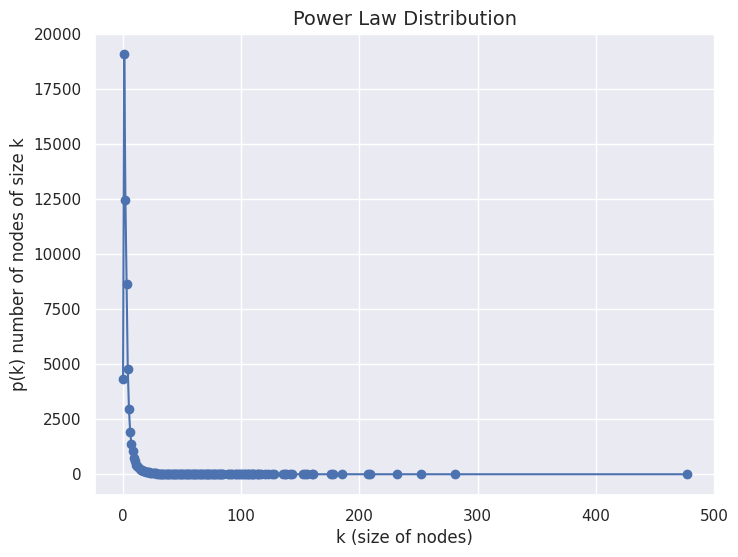

In [42]:
weighted_degree = G_ig.strength(weights=G_ig.es['weight'])
unique_degrees, counts = np.unique(weighted_degree, return_counts=True)
plt.figure(figsize=(8, 6))
plt.plot(unique_degrees, counts, marker='o', linestyle='-', color='b')


plt.title('Power Law Distribution', fontsize=14)
plt.xlabel('k (size of nodes)', fontsize=12)
plt.ylabel('p(k) number of nodes of size k', fontsize=12)

# Show the plot
plt.grid(True)
plt.show()

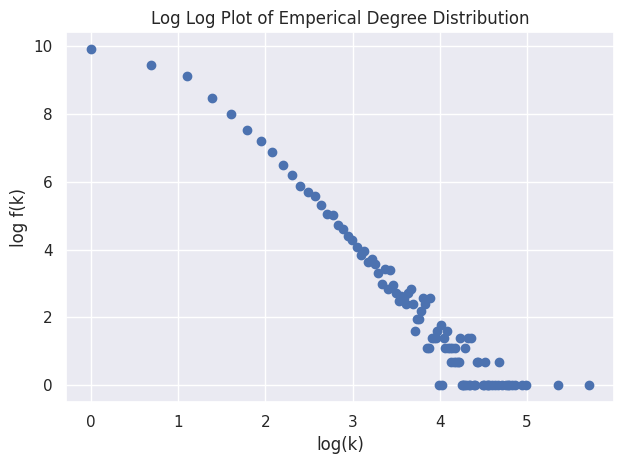

In [43]:

# Degree counts
deg = [d for _, d in G.degree()]
cnt = Counter(deg)
k = np.array(sorted(cnt.keys()))
n = np.array([cnt[kk] for kk in k])

# Using only positive degrees/counts for logs
m = (k > 0) & (n > 0)
k_log = np.log(k[m])
n_log = np.log(n[m])

plt.figure()
plt.plot(k_log, n_log, marker='o', linestyle='none')
plt.xlabel('log(k)')
plt.ylabel('log f(k)')
plt.title('Log Log Plot of Emperical Degree Distribution')
plt.tight_layout()
plt.show()


From the degree-distribution plot, **the network appears scale-free:** most nodes have very small degrees, while a few nodes act as high-degree “hubs.” This fits the setting, most guests pose with only a handful of close friends, whereas a few highly social or prominent attendees take photos with many people, creating those hub nodes and the long-tailed degree pattern. Also since the log log plot of emperical degree distribution plot is approximately a straight line, we can say that the graph is exhibiting a scale free property.

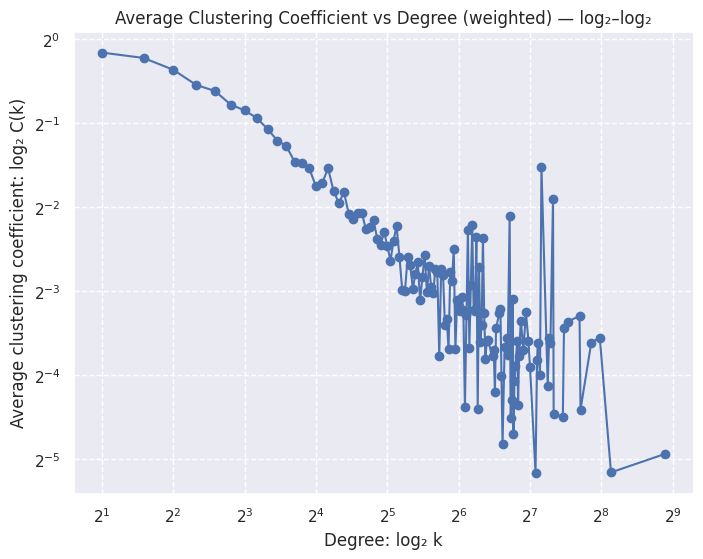

In [44]:


C = G_ig.transitivity_local_undirected(weights=G_ig.es['weight'])
K = G_ig.strength(weights=G_ig.es['weight'])

# average by degree (strength)
#k --> no of Nodes
deg2C = {}
for k, c in zip(K, C):
    if k > 0 and c is not None and not np.isnan(c):
        deg2C.setdefault(k, []).append(c)

degrees = np.array(sorted(deg2C))
avgC = np.array([np.mean(deg2C[k]) for k in degrees])


plt.figure(figsize=(8, 6))
plt.plot(degrees, avgC, marker='o')
plt.xscale('log', base=2); plt.yscale('log', base=2)
plt.title('Average Clustering Coefficient vs Degree (weighted) — log₂–log₂')
plt.xlabel('Degree: log₂ k')
plt.ylabel('Average clustering coefficient: log₂ C(k)')
plt.grid(True, which='both', ls='--')
plt.show()


This plot illustrates the relationship between a node's degree and its average clustering coefficient on a log-log scale.On the log₂ plot, the curve slopes downward, which is consistent with a heavy-tailed (power-law-like) degree distribution: most people have only a few links, while a small number act as hubs with many. The graph also shows clustering: if two people share a mutual friend, they’re more likely to be connected. In this party-photo setting, low-degree nodes tend to sit in tight friend groups (high clustering), whereas high-degree nodes act as hubs bridging groups (lower clustering).

## Question 4: Who are the most photogenic persons? (10 p)

The simplest question to ask is "who is the most popular"?  The easiest way to answer this question is to look at how many connections everyone has.  Return the top 100 people and their degree.  Remember that if an edge of the graph has weight 2, it counts for 2 in the degree.


In [45]:
deg_series = pd.Series(dict(G.degree(weight="weight")), dtype=float)
degree = list(deg_series.sort_values(ascending=False).head(100).items())
len(degree)
degree


[('Jean Shafiroff', 477.0),
 ('Mark Gilbertson', 281.0),
 ('Gillian Miniter', 252.0),
 ('Alexandra Lebenthal', 232.0),
 ('Kamie Lightburn', 209.0),
 ('Geoffrey Bradfield', 207.0),
 ('Eleanora Kennedy', 185.0),
 ('Yaz Hernandez', 178.0),
 ('Alina Cho', 176.0),
 ('Debbie Bancroft', 161.0),
 ('Bonnie Comley', 160.0),
 ('Lucia Hwong Gordon', 156.0),
 ('Somers Farkas', 154.0),
 ('Sharon Bush', 152.0),
 ('Stewart Lane', 143.0),
 ('Audrey Gruss', 141.0),
 ('Barbara Tober', 138.0),
 ('Martha Glass', 137.0),
 ('Martha Stewart', 135.0),
 ('Allison Aston', 128.0),
 ('Grace Meigher', 126.0),
 ('Jamee Gregory', 126.0),
 ('Muffie Potter Aston', 123.0),
 ('Lydia Fenet', 120.0),
 ('Diana Taylor', 117.0),
 ('Margaret Russell', 115.0),
 ('Deborah Norville', 114.0),
 ('Fe Fendi', 113.0),
 ('Barbara Regna', 111.0),
 ('Couri Hay', 110.0),
 ('Patrick McMullan', 110.0),
 ('Karen Klopp', 109.0),
 ('Janna Bullock', 108.0),
 ('Nicole Miller', 107.0),
 ('Mario Buatta', 106.0),
 ('Michael Bloomberg', 106.0),
 ('K

## Question 5: Centrality analysis (25 p)


Use eccentricity centrality, closeness centrality, betweenness centrality, prestige, and PageRank to identify the top 10 individuals with the highest centrality for each measure. How do you interpret the results?

Use 0.85 as the damping parameter for page rank, so that there is a 15% chance of jumping to another vertex at random.


###Data Exploration

For centrality analysis we had to find all connected components in G. That step took too long (>20 min), so instead we kept only the largest connected component, H. On H we computed eccentricity, betweenness, degree, closeness, and PageRank centrality.

In [49]:
H = G.subgraph(max(nx.connected_components(G), key=len)).copy()



In [50]:
print("Nodes:", H.number_of_nodes())
print("Edges:", H.number_of_edges())


Nodes: 31740
Edges: 74798


# Degree Centrality

Degree Centrality refers that the higher the degree, the more important or central the vertex. We ran degree centrality in both the maximum connected subgraph (H) and the entire graph (G), and both yielded the same list of people sequentially. The code below calculates degree centrality for all nodes and reports the top 10 individuals. Jean Shafiroff has the highest value, followed by Mark Gilbertson, Kamie Lightburn, Alexandra Lebenthal, and Alina Cho. Geoffrey Bradfield, Lucia Hwong Gordon, Debbie Bancroft, Gillian Miniter, and Martha Stewart also appear near the top. The top 10 most central people are the ones that are highly connected with others. These results confirm that degree centrality can be computed efficiently on the full network while still highlighting the most connected individuals.

In [62]:
deg = nx.degree_centrality(H)
pd.Series(deg).sort_values(ascending=False).head(10)

,0
Jean Shafiroff,0.009515
Mark Gilbertson,0.006679
Kamie Lightburn,0.004632
Alexandra Lebenthal,0.004411
Alina Cho,0.004064
Geoffrey Bradfield,0.003938
Lucia Hwong Gordon,0.003781
Debbie Bancroft,0.003749
Gillian Miniter,0.003686
Martha Stewart,0.003497


In [61]:
dc = nx.degree_centrality(G)
top10 = sorted(dc.items(), key=lambda x: x[1], reverse=True)[:10]
print(top10)

[('Jean Shafiroff', 0.004924903377309568), ('Mark Gilbertson', 0.003457216940363008), ('Kamie Lightburn', 0.002397221180346048), ('Alexandra Lebenthal', 0.00228306779080576), ('Alina Cho', 0.002103683892956736), ('Geoffrey Bradfield', 0.002038453384648), ('Lucia Hwong Gordon', 0.00195691524926208), ('Debbie Bancroft', 0.001940607622184896), ('Gillian Miniter', 0.001907992368030528), ('Martha Stewart', 0.001810146605567424)]


# Eccentricity

Eccentricity represents the maximum shortest path of the node to the other nodes. Thus lower the Eccentricity the more central the node is. In the code below we find the top eccentricity centrality to identify the top 10 individuals with the highest centrality for this measure. We used the subgraph having the maximum connected components to find the result. Interpreting the output, we see that Debbie Bancroft, Jamee Gregory, Bettina Zilkha, Dayssi Olarte, Robert Zimmerman, Mark Badgley, Jean Shafiroff, Audrey Gruss, Eric Ripert and Janna Bullock are the most centric nodes (each have eccentricity = 12), meaning they are twelve edges away from everyone else in the subgraph.

In [66]:
if not G_ig.is_connected():
  G_ig_new = G_ig.clusters().giant()
names = G_ig_new.vs['name']
eccentricity = G_ig_new.eccentricity()
top_eccentricity = sorted(zip(names, eccentricity), key=lambda x: x[1])[:10]
print(top_eccentricity)

/tmp/ipython-input-2707915369.py:2: DeprecationWarning: Graph.clusters() is deprecated; use Graph.connected_components() instead
  G_ig_new = G_ig.clusters().giant()


[('Debbie Bancroft', 12.0), ('Jamee Gregory', 12.0), ('Bettina Zilkha', 12.0), ('Dayssi Olarte', 12.0), ('Robert Zimmerman', 12.0), ('Mark Badgley', 12.0), ('Jean Shafiroff', 12.0), ('Audrey Gruss', 12.0), ('Eric Ripert', 12.0), ('Janna Bullock', 12.0)]


# Closeness Centrality

Closeness centrality measures how quickly an individual can interact with others in the network. In the code below we find the top closeness centrality. Jean Shafiroff ranks highest (0.26), followed by Mark Gilbertson and Alexandra Lebenthal. These individuals have the shortest average paths to others in the subgraph, meaning they can spread information or interact faster with others compared to others in the network. Debbie Bancroft, Alina Cho, Yaz Hernandez, Somers Farkas, Eleanora Kennedy, Gillian Miniter and Muffie Potter Aston also score highly, showing they remain closely connected to the rest of the network.

In [53]:
clo = nx.closeness_centrality(H)
pd.Series(clo).sort_values(ascending=False).head(10)


,0
Jean Shafiroff,0.259930
Mark Gilbertson,0.250913
Alexandra Lebenthal,0.250030
Debbie Bancroft,0.245772
Alina Cho,0.245629
Yaz Hernandez,0.244536
Somers Farkas,0.243893
Eleanora Kennedy,0.243822
Gillian Miniter,0.243481
Muffie Potter Aston,0.243349


# Betweenness Centrality

Betweenness centrality identifies individuals who act as bridges or mediators between other individuals. In the code below, we find the top betweenness centrality. Jean Shafiroff ranks highest, followed by Gillian Miniter, Alexandra Lebenthal, Debbie Bancroft, and Mark Gilbertson. These individuals appear most often on shortest paths between others, which suggests that they hold key positions in connecting otherwise distant parts of the network. Geoffrey Bradfield, Somers Farkas, Jamee Gregory, Sharon Bush, and Amy Fine Collins also rank high, showing they serve as central hubs in the network.

In [59]:
betweenness = G_ig.betweenness()
top_betweenness = sorted(zip(names, betweenness), key=lambda x: x[1], reverse=True)[:10]
print(top_betweenness)

[('Jean Shafiroff', 56797955.31904665), ('Mark Gilbertson', 29126415.50752838), ('Alexandra Lebenthal', 17657796.4066712), ('Alina Cho', 16435764.820762767), ('Geoffrey Bradfield', 15038859.701914236), ('Debbie Bancroft', 14518164.870602995), ('Kamie Lightburn', 14483953.753648374), ('Martha Stewart', 13486706.961048229), ('Gillian Miniter', 12532949.613188757), ('Patrick McMullan', 12283704.78714918)]


# PageRank  (𝛼=0.85)

In the code below, we find the top PageRank centrality. Jean Shafiroff has the highest score, followed by Mark Gilbertson, Alexandra Lebenthal, Gillian Miniter, and Geoffrey Bradfield. Jamee Gregory, Debbie Bancroft, Somers Farkas, Kamie Lightburn, and Yaz Hernandez also rank high. PageRank highlights individuals whose edges connect to other high rank nodes, increasing their importance in the network. Here the same name like Jean Shafiroff, Mark Gilbertson and Michael Bloomberg can only imply that they are central figures not only through their direct connections but also through the connections of those they are linked to others

In [63]:
pr = nx.pagerank(H, alpha=0.85)
pd.Series(pr).sort_values(ascending=False).head(10)


,0
Jean Shafiroff,0.001730
Mark Gilbertson,0.001060
Alexandra Lebenthal,0.000804
Gillian Miniter,0.000795
Geoffrey Bradfield,0.000767
Kamie Lightburn,0.000765
Alina Cho,0.000647
Yaz Hernandez,0.000630
Barbara Tober,0.000612
Debbie Bancroft,0.000609


We also ran PageRank directly on the full graph G. It completed quickly and gave results very close to those from the subgraph H. The top four individuals (Jean Shafiroff, Mark Gilbertson, Gillian Miniter, Alexandra Lebenthal) are consistent across both, and others like Kamie Lightburn and Jamee Gregory also appear in the top ranks. This overlap shows that while subgraph sampling makes heavy measures feasible, the full network confirms that the same actors dominate, reinforcing the robustness of the results.

In [64]:
pr = nx.pagerank(G, alpha=0.85)
pd.Series(pr).sort_values(ascending=False).head(10)

,0
Jean Shafiroff,0.000934
Mark Gilbertson,0.000567
Alexandra Lebenthal,0.000431
Gillian Miniter,0.000424
Kamie Lightburn,0.000414
Geoffrey Bradfield,0.000413
Alina Cho,0.000349
Yaz Hernandez,0.000338
Barbara Tober,0.000331
Debbie Bancroft,0.000330


Eccentricity represents the maximum shortest path of the node to the other nodes. Thus lower the Eccentricity the more central the node is. Given that
information the node Jean Shafiroff, Mark Gilbertson, Tatiana Platt and Stephanie Hessler are the most centric nodes. It takes them at most 11 jumps to reach any node in the
graph (Given that there is a way can reach that node).

## Question 6: best_friends (10 p)


Another interesting question is who tend to co-occur with each other.  Give us the 100 edges with the highest weights.

Google these people and see what their connection is.  Can we use this to detect instances of infidelity?


In [71]:
best_friends = []
w = nx.get_edge_attributes(G, "weight")
best_friends = sorted(w.items(), key=lambda x: x[1], reverse=True)[:100]
best_friends

[(('Bonnie Comley', 'Stewart Lane'), 56),
 (('Gillian Miniter', 'Sylvester Miniter'), 53),
 (('Geoffrey Bradfield', 'Roric Tobin'), 41),
 (('Jamee Gregory', 'Peter Gregory'), 38),
 (('Jean Shafiroff', 'Martin Shafiroff'), 36),
 (('Barbara Tober', 'Donald Tober'), 36),
 (('Alexandra Lebenthal', 'Jay Diamond'), 33),
 (('Grace Meigher', 'Chris Meigher'), 28),
 (('Somers Farkas', 'Jonathan Farkas'), 25),
 (('John Catsimatidis', 'Margo Catsimatidis'), 25),
 (('Barbara Regna', 'Peter Regna'), 25),
 (('Yaz Hernandez', 'Valentin Hernandez'), 24),
 (('Janna Bullock', 'Couri Hay'), 22),
 (('Mark Badgley', 'James Mischka'), 21),
 (('Eleanora Kennedy', 'Michael Kennedy'), 21),
 (('Guy Robinson', 'Elizabeth Stribling'), 21),
 (('Andrew Saffir', 'Daniel Benedict'), 21),
 (('Eleanora Kennedy', 'Anna Safir'), 20),
 (('Arie Kopelman', 'Coco Kopelman'), 20),
 (('Jay McInerney', 'Anne Hearst McInerney'), 19),
 (('Jonathan Tisch', 'Lizzie Tisch'), 19),
 (('Campion Platt', 'Tatiana Platt'), 18),
 (('Debora



*   Bonnie Comley & Stewart Lane are married and also well-known for "Broadway power couple. Hence, it makes sense that they are 'best friends'

*   Gillian Miniter & Sylvester Miniter are also a married couple.

*   Geoffrey Bradfield and Roric Tobin are professional partners—they work together as design/business partners (co-leaders of an interior design practice). Thus, they were seen many times together.

*  Both Jamee Gregory & Peter Gregory and Jean Shafiroff & Martin Shafiroff are married couples.



Hence, we can say that most of the “best friend” duos are married. However, if two people appear together in many photos—enough to be classified as a “best friend” duo—they might be business partners, or there might be a hint of infidelity between them. Nevertheless, without stronger evidence, infidelity cannot be alleged against any “best friend” duo in the pictures.